In [1]:
def extract_triggers(df_event, onset_pattern, offset_pattern): 
    """
    Extract eye-tracking data and trial trigger events from event and data frames.

    Args:
        df_event (pd.DataFrame): Event dataframe (physioevents)
        df_data (pd.DataFrame): Eye-tracking data with timestamps (physio)
        onset_pattern (str): Regex pattern to detect the start of trials.
        offset_pattern (str): Regex pattern to detect the end of trials.

    Returns:
        tuple: Numpy array of eye-tracking data within the trial period, start time, and end time of the trial.
    """

    # Extract triggers
    # Initialize arrays to store results
    import re 
    import pandas as pd
    import matplotlib.pyplot as plt
    
    time_start_eye = 0
    time_end_eye = 0
    # Loop through the 'messages' column to extract the patterns

    for index, row in df_event.iterrows():
        message = row['message']
        
        if pd.isna(message):
            continue  # Skip if NaN
        
        
        if re.search(onset_pattern, message):
            time_start_eye = row['onset']  # Store by run index
            
        
        
        if re.search(offset_pattern, message):
            time_end_eye = row['onset']
    
    return [time_start_eye,time_end_eye]
    
    

In [7]:
import json
import pandas as pd
def load_data_events(subject, task, run):
    json_file_path = f"/Users/sinakling/disks/meso_shared/deepmreye/{subject}/ses-02/func/{subject}_ses-02_task-{task}_run-0{run+1}_eyetrack_recording-eye1_physioevents.json"
    tsv_file_path = f"/Users/sinakling/disks/meso_shared/deepmreye/{subject}/ses-02/func/{subject}_ses-02_task-{task}_run-0{run+1}_eyetrack_recording-eye1_physioevents.tsv.gz"


    with open(json_file_path, 'r') as file:
        json_data = json.load(file)

    # Extract column names from the JSON
    column_names = json_data['Columns']

    df_events = pd.read_csv(
        tsv_file_path, 
        compression='gzip', 
        delimiter='\t', 
        header=None,  
        names=column_names,  # Use the column names from JSON
        na_values='n/a'  # Treat 'n/a' as NaN
    )
    return df_events

df_events = load_data_events("sub-06", "DeepMReyeCalib", 0)
iti_1_trigger = extract_triggers(df_events, "iti\s1\sonset\sat", "iti\s1\soffset\sat")
iti_2_trigger = extract_triggers(df_events, "iti\s52\sonset\sat", "iti\s52\soffset\sat")
iti_3_trigger = extract_triggers(df_events, "iti\s107\sonset\sat", "iti\s107\soffset\sat")
iti_4_trigger = extract_triggers(df_events, "iti\s118\sonset\sat", "iti\s118\soffset\sat")

fix_trigger = extract_triggers(df_events, "fixation\s2\sonset\sat", "fixation\s51\soffset\sat")
pur_trigger = extract_triggers(df_events, "pursuit\s53\sonset\sat", "pursuit\s106\soffset\sat")
fv_trigger = extract_triggers(df_events, "freeview\s108\sonset\sat", "freeview\s117\soffset\sat")


In [2]:
import pandas as pd
import numpy as np
def adapt_evaluation(participant_evaluation):
    pred_y = participant_evaluation["pred_y"]
    pred_y_median = np.nanmedian(pred_y, axis=1)
    pred_uncertainty = abs(participant_evaluation["euc_pred"])
    pred_uncertainty_median = np.nanmedian(pred_uncertainty, axis=1)
    df_pred_median = pd.DataFrame(
        np.concatenate(
            (pred_y_median, pred_uncertainty_median[..., np.newaxis]), axis=1),
        columns=["X", "Y", "Uncertainty"],
    )
    # With subTR
    subtr_values = np.concatenate((pred_y, pred_uncertainty[..., np.newaxis]),
                                  axis=2)
    index = pd.MultiIndex.from_product(
        [range(subtr_values.shape[0]),
         range(subtr_values.shape[1])],
        names=["TR", "subTR"])
    df_pred_subtr = pd.DataFrame(subtr_values.reshape(-1,
                                                      subtr_values.shape[-1]),
                                 index=index,
                                 columns=["X", "Y", "pred_error"])

    return df_pred_median, df_pred_subtr

In [22]:
#Load the eye data
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
eye_data = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/sub-03/eyetracking/sub-03_task-DeepMReyeCalib_run_01_eyedata.tsv.gz", compression='gzip', delimiter='\t')
eye_data = eye_data[['timestamps','x', 'y']].to_numpy()

eye_data_closed = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/sub-03/eyetracking/sub-03_task-DeepMReyeClosed_run_01_eyedata.tsv.gz", compression='gzip', delimiter='\t')
eye_data_closed = eye_data_closed[['timestamps','x', 'y']].to_numpy()

In [31]:
evaluation = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib.npy", allow_pickle=True).item()
sub_03_ft = evaluation["/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data/sub-03_DeepMReyeCalib_label.npz"]
pred_y = sub_03_ft["pred_y"]
df_pred_median_03, df_pred_subtr_03 = adapt_evaluation(sub_03_ft)
sub_03_run_01_X = np.array(df_pred_subtr_03['X'][:1540])
sub_03_run_01_Y = np.array(df_pred_subtr_03['Y'][:1540])

In [44]:
evaluation_pretrained = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_pretrained.npy", allow_pickle=True).item()
sub_03_pt = evaluation_pretrained["/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_pretrained/sub-03_DeepMReyeCalib_no_label.npz"]
df_pred_median_3_pt, df_pred_subtr_3_pt = adapt_evaluation(sub_03_pt)
sub_03_run_01_pt_X = np.array(df_pred_subtr_3_pt['X'][:1540])
sub_03_run_01_pt_Y = np.array(df_pred_subtr_3_pt['Y'][:1540])

In [42]:
evaluation_closed = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_closed/pred/evaluation_dict_closed.npy", allow_pickle=True).item()
sub_06_closed = evaluation_closed["/scratch/mszinte/data/deepmreye/derivatives/deepmreye_closed/pp_data/sub-03_DeepMReyeClosed_label.npz"]
df_pred_median_6, df_pred_subtr_6 = adapt_evaluation(sub_06_closed)
sub_06_run_01_closed_X = np.array(df_pred_subtr_6['X'][:3130])
sub_06_run_01_closed_Y = np.array(df_pred_subtr_6['Y'][:3130])

In [33]:
evaluation_closed_pt = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_closed/pred/evaluation_dict_closed_pretrained.npy", allow_pickle=True).item()
sub_06_closed_pt = evaluation_closed_pt["/scratch/mszinte/data/deepmreye/derivatives/deepmreye_closed/pp_data_pretrained/sub-06_DeepMReyeClosed_no_label.npz"]
df_pred_median_6_pt, df_pred_subtr_6_pt = adapt_evaluation(sub_06_closed_pt)
sub_06_run_01_closed_X_pt = np.array(df_pred_subtr_6_pt['X'][:3130])
sub_06_run_01_closed_Y_pt = np.array(df_pred_subtr_6_pt['Y'][:3130])

In [15]:
evaluation_calib_no_invers = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_calib/pred/evaluation_dict_calib_no_invers.npy", allow_pickle=True).item()
print(evaluation_calib_no_invers.keys())
sub_11_no_invers = evaluation_calib_no_invers["/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_invers/sub-11_DeepMReyeCalib_label_no_invers.npz"]
df_pred_median_11, df_pred_subtr_11 = adapt_evaluation(sub_11_no_invers)
sub_11_no_invers_X = np.array(df_pred_subtr_11['X'][:1540])
sub_11_no_invers_Y = np.array(df_pred_subtr_11['Y'][:1540])
#


dict_keys(['/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_invers/sub-11_DeepMReyeCalib_label_no_invers.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_invers/sub-05_DeepMReyeCalib_label_no_invers.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_invers/sub-15_DeepMReyeCalib_label_no_invers.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_invers/sub-14_DeepMReyeCalib_label_no_invers.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_invers/sub-09_DeepMReyeCalib_label_no_invers.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_invers/sub-07_DeepMReyeCalib_label_no_invers.npz', '/scratch/mszinte/data/deepmreye/derivatives/deepmreye_calib/pp_data_no_invers/sub-04_DeepMReyeCalib_label_no_invers.npz'])


In [8]:
# add extra column of "time"/duration for prediction 
# Calculate the time step (in seconds)
sampling_frequency = 10  # 10 data points per 1.2 seconds
time_step = 1.2 / sampling_frequency  # 0.12 seconds per sample

# Create the cumulative time array (in seconds)
time_array_X = np.arange(0, len(sub_11_no_invers_X) * time_step, time_step)  # Shape: (n_data_points,)

print(time_array_X)

# Combine the x-coordinates and time as a 2D array
#result_X = np.stack((sub_11_no_invers_X , time_array_X), axis=-1)  # Shape: (n_data_points, 2)

#time_array_Y = np.arange(0, len(sub_06_run_01_Y ) * time_step, time_step)  # Shape: (n_data_points,)

# Combine the x-coordinates and time as a 2D array
#result_Y = np.stack((sub_06_run_01_Y , time_array_Y), axis=-1)  # Shape: (n_data_points, 2)

[0.0000e+00 1.2000e-01 2.4000e-01 ... 1.8444e+02 1.8456e+02 1.8468e+02]


In [27]:
import numpy as np

def chunk_and_median(eyetracking_data, sampling_rate=1000, chunk_duration=1.2):
    """
    Splits continuous eyetracking data into chunks of specified duration
    and computes the median for each chunk, ensuring no NaNs are returned.

    Parameters:
    - eyetracking_data: 1D NumPy array (continuous signal)
    - sampling_rate: int, samples per second (default: 1000 Hz)
    - chunk_duration: float, duration of each chunk in seconds (default: 1.2 s)

    Returns:
    - medians: 1D NumPy array with median values per chunk
    """
    # Remove NaNs from input
    eyetracking_data = np.nan_to_num(eyetracking_data, nan=0.0)

    chunk_size = int(sampling_rate * chunk_duration)
    num_chunks = len(eyetracking_data) // chunk_size

    medians = np.array([
        np.nanmedian(eyetracking_data[i * chunk_size: (i + 1) * chunk_size])  # Ensures NaN-safe median
        for i in range(num_chunks)
    ])

    return medians



In [28]:
eye_data_downsampled_x = chunk_and_median(eye_data[:,1])     
eye_data_downsampled_y = chunk_and_median(eye_data[:,2])
eye_data_downsampled = np.stack((eye_data_downsampled_x, eye_data_downsampled_y), axis=1)

In [29]:
import numpy as np

# Example: target_positions has shape (num_datapoints, 2), containing (x, y) positions
def filter_positions(target_positions, limit=5):
    """
    Filters datapoints where the target stays within a 5x5 dva window (centered at 0,0).
    
    Parameters:
        target_positions (numpy array): Shape (num_datapoints, 2), containing (x, y) positions.
        limit (float): Half of the desired window size (default 2.5 for a 5x5 window).
    
    Returns:
        filtered_positions (numpy array): Subset of target_positions within the 5x5 dva window.
        indices (numpy array): Indices of selected datapoints.
    """
    # Check which points fall within the 5x5 dva window
    within_bounds = (np.abs(target_positions[:, 0]) <= limit) & (np.abs(target_positions[:, 1]) <= limit)
    
    # Extract only the valid positions
    filtered_positions = target_positions[within_bounds]
    
    return filtered_positions, np.where(within_bounds)[0]

# Example usage
filtered_positions, indices = filter_positions(eye_data_downsampled)

print(f"Number of valid datapoints: {len(indices)}")
print(f"Selected indices: {indices}")



Number of valid datapoints: 81
Selected indices: [  0   1   2   3   4   5   7   8   9  11  15  19  24  26  29  30  33  35
  36  43  44  49  51  55  56  57  58  59  60  63  64  67  69  70  71  72
  73  74  77  78  80  84  85  87  88  90  91  92  93  94  97  98 109 110
 111 113 114 115 116 117 118 119 121 122 126 129 131 133 134 135 136 137
 138 140 143 146 149 150 151 152 153]


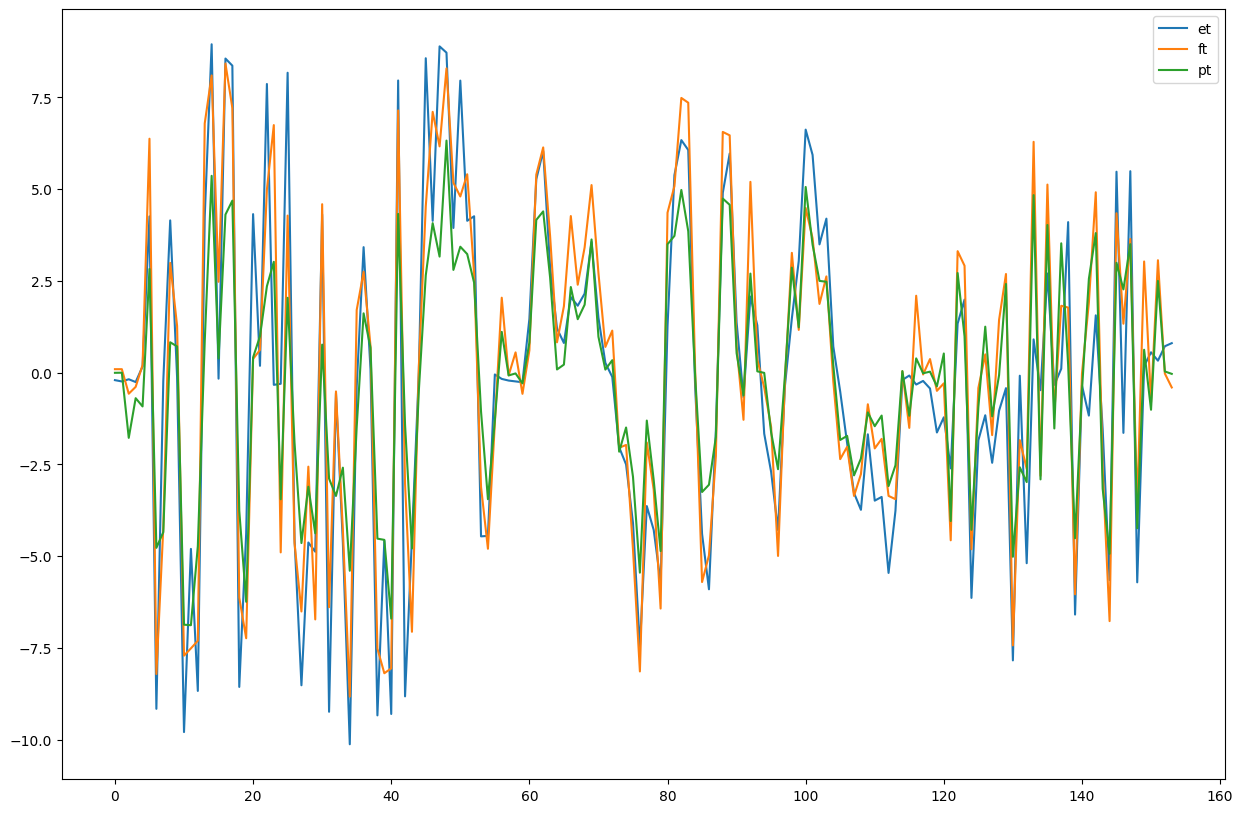

In [57]:

plt.figure(figsize=(15, 10))
plt.plot(eye_data_downsampled_x, label = 'et')
plt.plot(np.array(df_pred_median_03['X'])[:154], label = "ft")
plt.plot(np.array(df_pred_median_3_pt['X'][:154]), label = 'pt')

plt.legend()


In [64]:
df_pred_median_03_x_filtered = np.array(df_pred_median_03['X'])[indices]
df_pred_median_03_y_filtered = np.array(df_pred_median_03['Y'])[indices]

df_pred_median_03_pt_x_filtered = np.array(df_pred_median_3_pt['X'])[indices]
df_pred_median_03_pt_y_filtered = np.array(df_pred_median_3_pt['Y'])[indices]


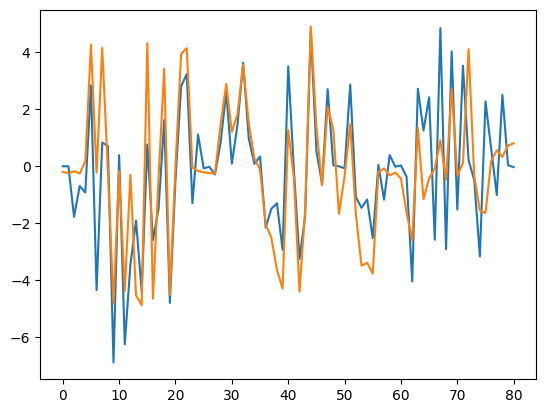

In [48]:
plt.plot(df_pred_median_03_pt_x_filtered)
plt.plot(filtered_positions[:,0])

In [65]:
df_pred_median_03_pt_y_filtered = -1 * df_pred_median_03_pt_y_filtered

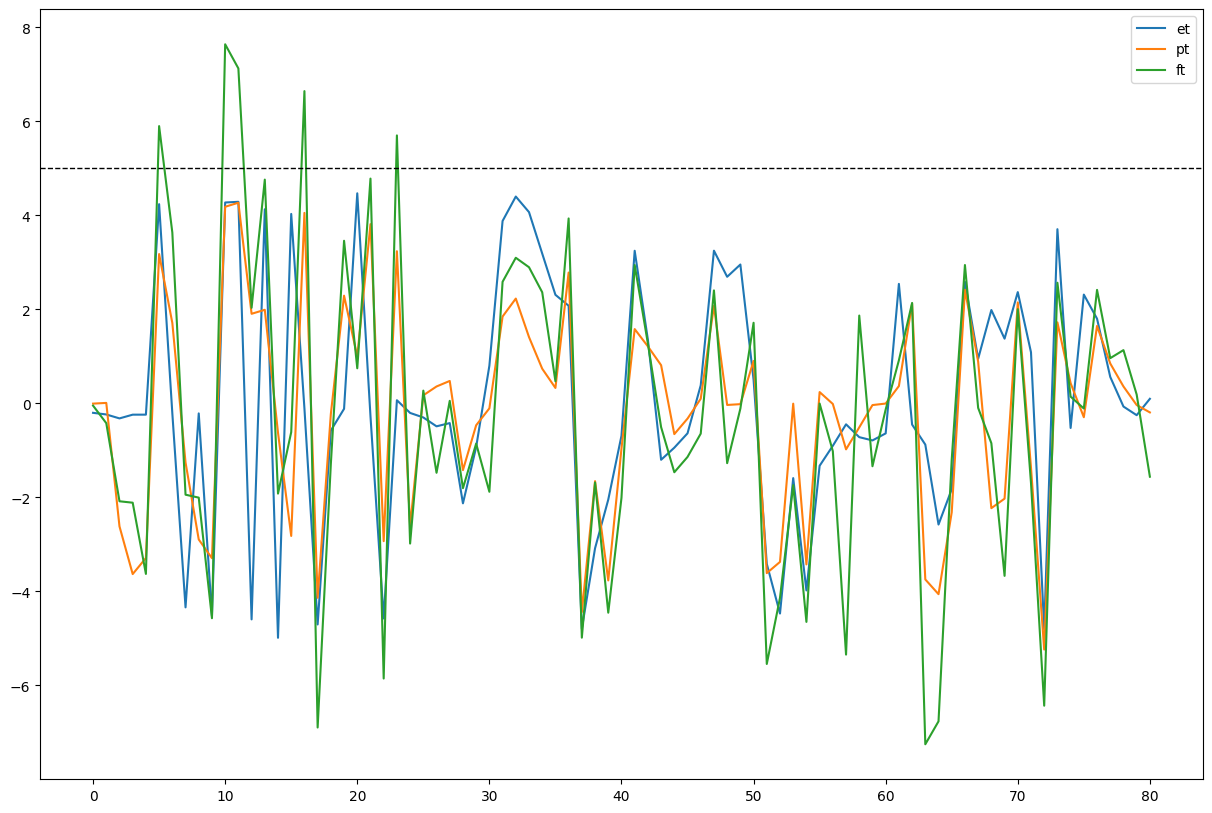

In [66]:


plt.figure(figsize=(15, 10))
plt.plot(filtered_positions[:,1], label = 'et')
plt.plot(df_pred_median_03_pt_y_filtered, label = 'pt')
plt.plot(df_pred_median_03_y_filtered, label = 'ft')
# Add a horizontal dashed line at y = 5
plt.axhline(y=5, color='black', linestyle='--', linewidth=1)

plt.legend()

/var/folders/v8/zmb9hj_97tjcq8mb570v8wq40000gp/T/ipykernel_7021/2917301944.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


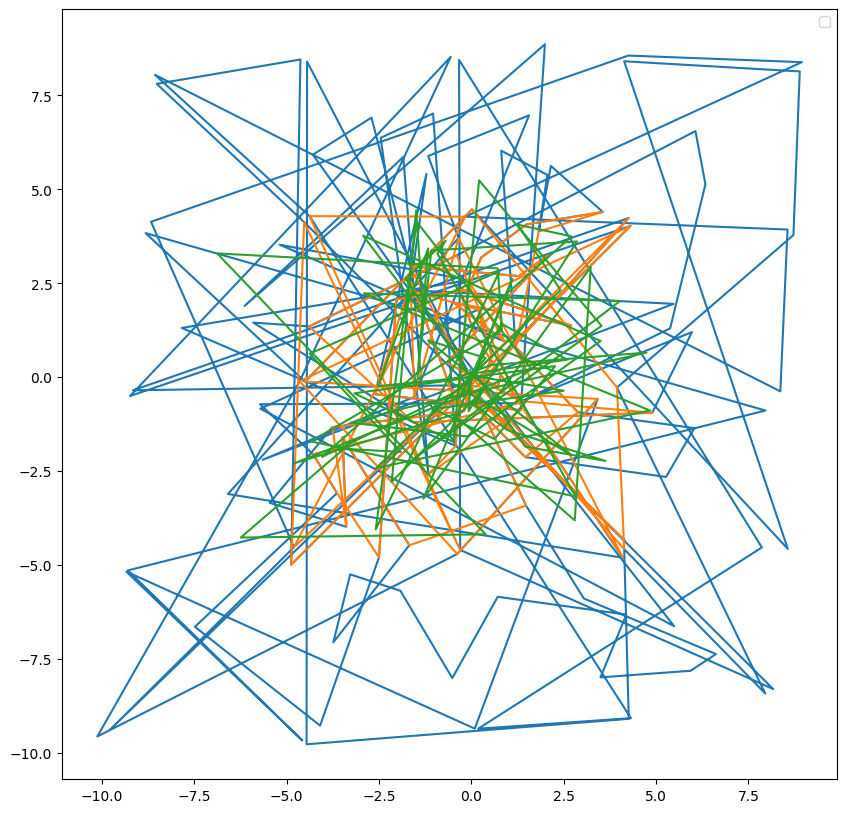

In [49]:
time_eye = (eye_data[:,0] - eye_data[0,0]) / 1000


plt.figure(figsize=(10, 10))
#plt.plot(time_eye, eye_data[:,2], label = "eyedata")
plt.plot(eye_data_downsampled[:,0], eye_data_downsampled[:,1])
plt.plot(filtered_positions[:,0], filtered_positions[:,1])
plt.plot(df_pred_median_03_pt_x_filtered, df_pred_median_03_pt_y_filtered)

plt.legend()

In [31]:
sampling_frequency = 10  # 10 data points per 1.2 seconds
time_step = 1.2 / sampling_frequency  # 0.12 seconds per sample

# Create the cumulative time array (in seconds)
time_array_closed_X = np.arange(0, len(sub_06_run_01_closed_X ) * time_step, time_step)  # Shape: (n_data_points,)

# Combine the x-coordinates and time as a 2D array
#result_closed_X = np.stack((sub_06_run_01_closed_X , time_array_closed_X), axis=-1)  # Shape: (n_data_points, 2)
print(time_array_closed_X)

[0.0000e+00 1.2000e-01 2.4000e-01 ... 3.7524e+02 3.7536e+02 3.7548e+02]


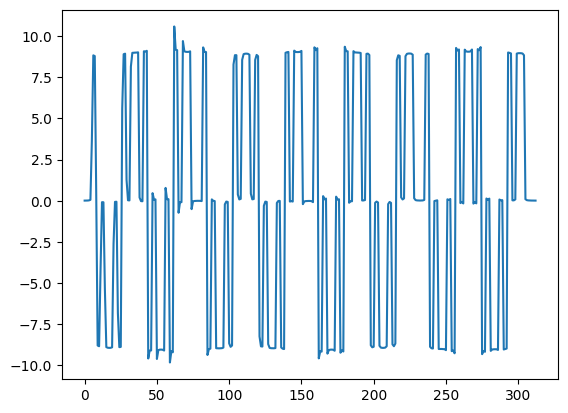

In [45]:
expected = np.load("/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_closed/model/sim_labels/expected_position_closed.npy")

plt.plot(expected[:,0,0])

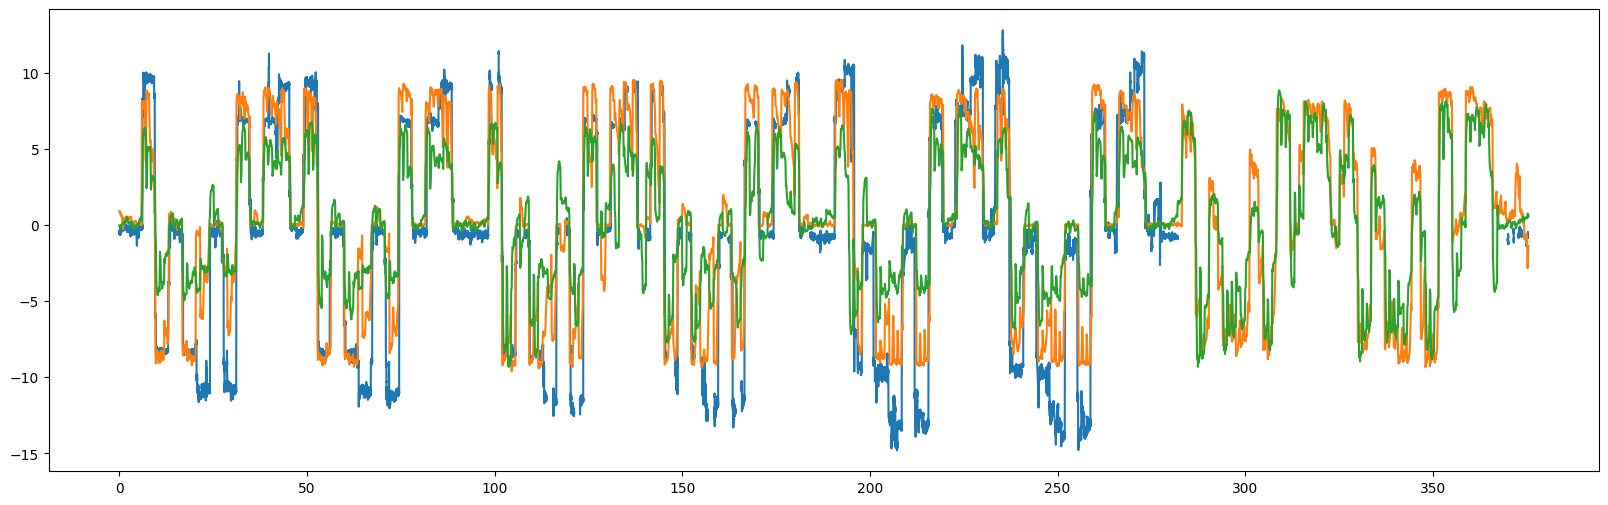

In [43]:
time_eye = (eye_data_closed[:,0] - eye_data_closed[0,0]) / 1000

plt.figure(figsize=(20, 6))
plt.plot(time_eye, eye_data_closed[:,1])
plt.plot(time_array_closed_X, sub_06_run_01_closed_X)
plt.plot(time_array_closed_X, sub_06_run_01_closed_X_pt)


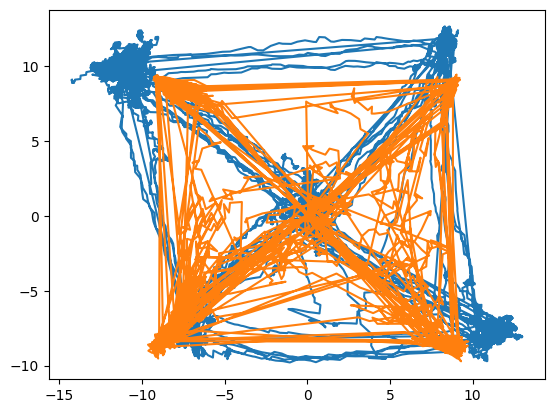

In [36]:
plt.plot(eye_data_closed[:,1],eye_data_closed[:,2])
plt.plot(sub_06_run_01_closed_X,sub_06_run_01_closed_Y)

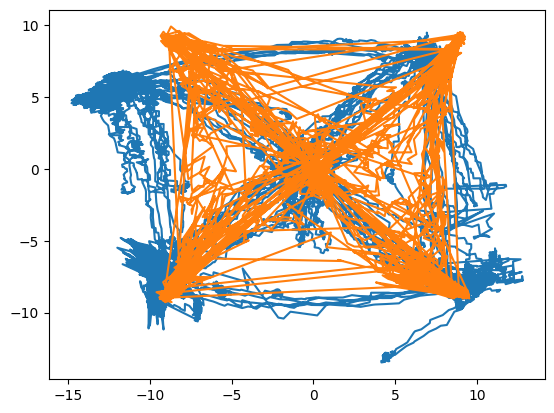

In [44]:
plt.plot(eye_data_closed[:,1],eye_data_closed[:,2])
plt.plot(sub_06_run_01_closed_X,sub_06_run_01_closed_Y)

In [ ]:
import plotly.graph_objects as go
import numpy as np
import os



N = len(sub_06_run_01_closed_X[:800])
x = sub_06_run_01_closed_X[:800]
#[::150]
y = sub_06_run_01_closed_Y[:800]

# Create output directory for frames
output_dir = f"/Users/sinakling/Desktop/frames_task_1"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Capture each frame and save as PNG
for k in range(N): 
    fig = go.Figure( 
        data=[ go.Scatter(x=x[:k+1], 
                            y=y[:k+1], 
                            mode="lines", 
                            line=dict(width=2, color="black")), ], 
                            layout=go.Layout( xaxis=dict(range=[-15, 15], 
                                                        autorange=False, 
                                                        zeroline=False), 
                                                        yaxis=dict(range=[-15, 15], 
                                                                    autorange=False, 
                                                                    zeroline=False), 
                                                                    title_text="DeepMReyeClosed Task 1", 
                                                                    hovermode="closest", 
                                                                    template='simple_white' ), ) 
    # Adjust layout for a square plot 
    fig.update_layout( autosize=False, width=800, height=800, margin=dict( l=50, r=50, b=100, t=100 ) ) 

    # Save each frame as a PNG file 
    fig.write_image(f"{output_dir}/frame_{k:03d}.png")

# Display the initial figure for verification
fig.show()


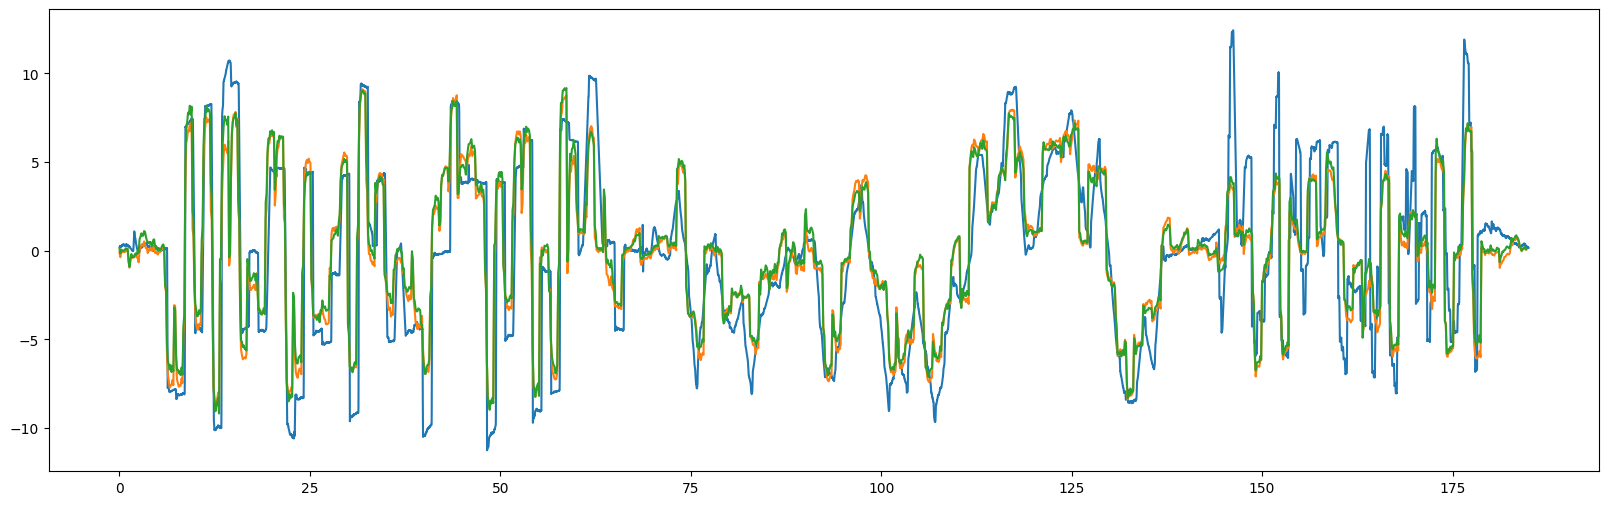

In [27]:
time_eye = (eye_data[:,0] - eye_data[0,0]) / 1000
plt.figure(figsize=(20, 6))
plt.plot(time_eye, eye_data[:,1])
plt.plot(time_array_X,sub_06_run_01_X)
plt.plot(time_array_X,sub_06_run_01_pt_X_test)

In [ ]:
# sub 03 

# iti 1 onset 4962110
# iti 1 offset 4968104
# fixation 1 onset 4968120
# fixation 51 offset 5028157
# iti 2 onset 5028164
# iti 2 offset 5034159
# pursuit onset 5034176
# pursuit offset 5099006
# iti 3 onset 5099013
# iti 3 offset 5105009
# freeview onset 5105032
# freeview offset 5141196
# iti 4 onset 5141203
# iti 4 offset 5147198


# sub 06

# iti 1 onset 4055811
# iti 1 offset 4061804
# fixation 1 onset 4061811
# fixation 51 offset 4121841
# iti 2 onset 4121848
# iti 2 offset 4127844
# pursuit onset 4127850
# pursuit offset 4192674
# iti 3 onset 4192681
# iti 3 offset 4198677
# freeview onset 4198692
# freeview offset 4234788
# iti 4 onset 4234795
# iti 4 offset 4240790



In [8]:
timestamps = eye_data[:,0]

#sub 03
start_trigger_fix = 4962110
end_trigger_fix = 5034159
fix_idx = np.where((timestamps>start_trigger_fix) & (timestamps< end_trigger_fix))
fix_data = eye_data[fix_idx,:]

start_trigger_iti2 = 5028164
end_trigger_iti2 = 5034159
iti2_idx = np.where((timestamps>start_trigger_iti2) & (timestamps< end_trigger_iti2))
iti2_data = eye_data[iti2_idx,:]

start_trigger_pur = 5028164
end_trigger_pur = 5105009
pur_idx = np.where((timestamps>start_trigger_pur) & (timestamps< end_trigger_pur))
pur_data = eye_data[pur_idx,:]

start_trigger_iti3 = 5099013
end_trigger_iti3 = 5105009
iti3_idx = np.where((timestamps>start_trigger_iti3) & (timestamps< end_trigger_iti3))
iti3_data = eye_data[iti3_idx,:]


start_trigger_fv = 5099013
end_trigger_fv = 5147198
fv_idx = np.where((timestamps>start_trigger_fv) & (timestamps< end_trigger_fv))
fv_data = eye_data[fv_idx,:]


In [12]:
timestamps = eye_data[:,0]

#sub 06
start_trigger_fix = 4055811
end_trigger_fix = 4127844
fix_idx = np.where((timestamps>start_trigger_fix) & (timestamps< end_trigger_fix))
fix_data = eye_data[fix_idx,:]

start_trigger_pur = 4121848
end_trigger_pur = 4198677
pur_idx = np.where((timestamps>start_trigger_pur) & (timestamps< end_trigger_pur))
pur_data = eye_data[pur_idx,:]


start_trigger_fv = 4192681
end_trigger_fv = 4240790
fv_idx = np.where((timestamps>start_trigger_fv) & (timestamps< end_trigger_fv))
fv_data = eye_data[fv_idx,:]


In [57]:
print(fix_data.shape)

(1, 72032, 3)


TODO: save timestamps during preprocessing
downsample eyetracking to 10 Hz (same as deepmreye)

In [14]:
time_seconds_fix = (fix_data[0,:, 0] - fix_data[0,0, 0]) / 1000  #72.047
time_seconds_pur = (pur_data[0,:, 0] - pur_data[0,0, 0]) / 1000  #76.843
time_seconds_fv = (fv_data[0,:, 0] - fv_data[0,0, 0]) / 1000     #48.183




In [66]:
fix_data_ft_X = result_X[result_X[:, 1] <= int(time_seconds_fix[-1])]
pur_data_ft_X = result_X[(result_X[:, 1] >= (int(time_seconds_fix[-1])- int(time_seconds_iti2[-1]))) & (result_X[:, 1] <= (int(time_seconds_fix[-1])+int(time_seconds_pur[-1])- int(time_seconds_iti3[-1])))]
fv_data_ft = result_X[(result_X[:, 1] >= (int(time_seconds_pur[-1])- int(time_seconds_iti3[-1]))) & (result_X[:, 1] <= (int(time_seconds_pur[-1])+int(time_seconds_fv[-1])- int(time_seconds_iti3[-1])))]

In [15]:
# X fine tuned
fix_data_ft_X = result_X[result_X[:, 1] <= int(time_seconds_fix[-1])]
pur_data_ft_X = result_X[(result_X[:, 1] >= 66) & (result_X[:, 1] <= 142)]
fv_data_ft_X = result_X[(result_X[:, 1] >= 137) & (result_X[:, 1] <= 185)]  #check why not aligned with 136 and 186

In [16]:
# Y fine tuned
fix_data_ft_Y = result_Y[result_Y[:, 1] <= int(time_seconds_fix[-1])]
pur_data_ft_Y = result_Y[(result_Y[:, 1] >= 66) & (result_Y[:, 1] <= 142)]
fv_data_ft_Y = result_Y[(result_Y[:, 1] >= 137) & (result_Y[:, 1] <= 185)]  #check why not aligned with 136 and 186

In [116]:
# X pretrained
fix_data_pt_X = result_X_pt[result_X_pt[:, 1] <= int(time_seconds_fix[-1])]
pur_data_pt_X = result_X_pt[(result_X_pt[:, 1] >= 66) & (result_X_pt[:, 1] <= 142)]
fv_data_pt_X = result_X_pt[(result_X_pt[:, 1] >= 137) & (result_X_pt[:, 1] <= 185)]  #check why not aligned with 136 and 186

In [117]:
# Y pretrained
fix_data_pt_Y = result_Y_pt[result_Y_pt[:, 1] <= int(time_seconds_fix[-1])]
pur_data_pt_Y = result_Y_pt[(result_Y_pt[:, 1] >= 66) & (result_Y_pt[:, 1] <= 142)]
fv_data_pt_Y = result_Y_pt[(result_Y_pt[:, 1] >= 137) & (result_Y_pt[:, 1] <= 185)]  #check why not aligned with 136 and 186

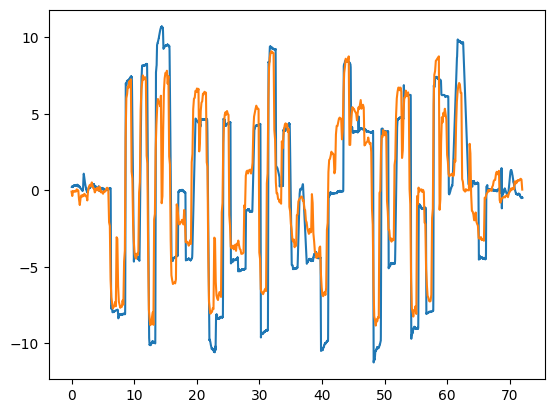

In [17]:
plt.plot(time_seconds_fix,fix_data[0,:,1])
plt.plot(fix_data_ft_X[:, 1], fix_data_ft_X[:,0])
#plt.plot(fix_data_pt_X[:, 1], fix_data_pt_X[:,0])

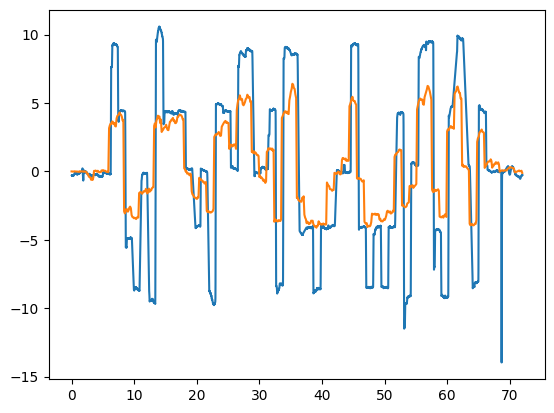

In [106]:
fix_pt_Y_inverted = -1.0 * fix_data_pt_Y[:,0]
plt.plot(time_seconds_fix,fix_data[0,:,2])
plt.plot(fix_data_pt_Y[:, 1], fix_pt_Y_inverted)

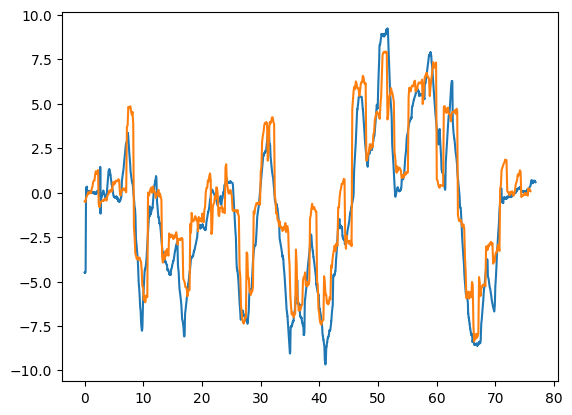

In [96]:
pur_data_ft_adjusted_time = pur_data_ft_X[:, 1] - pur_data_ft_X[0, 1]
pur_data_ft_adjusted_time_Y = pur_data_ft_Y[:, 1] - pur_data_ft_Y[0, 1]
plt.plot(time_seconds_pur,pur_data[0,:,1])
plt.plot(pur_data_ft_adjusted_time, pur_data_ft_X[:,0])

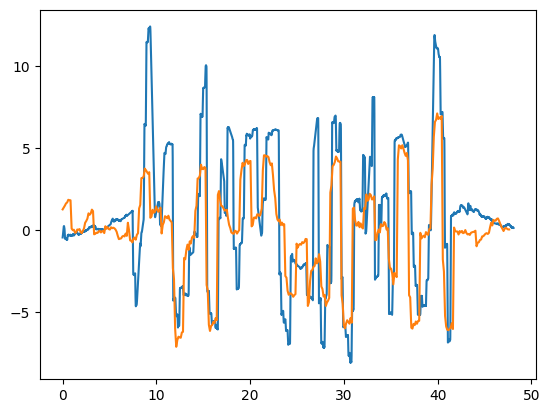

In [54]:
fv_data_ft_adjusted_time = fv_data_ft[:, 1] - fv_data_ft[0, 1]
plt.plot(time_seconds_fv,fv_data[0,:,1])
plt.plot(fv_data_ft_adjusted_time, fv_data_ft[:,0])

In [20]:
import pandas as pd
import plotly.graph_objects as go

# Load the data
ee_run_01 = pd.read_csv(
    "/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/sub-06/eyetracking/sub-06_task-DeepMReyeCalib_subtask-all_run_01_ee.tsv.gz",
    compression='gzip',
    delimiter='\t'
)
ee_run_01 = ee_run_01[['ee']].to_numpy()

# Create the figure
fig = go.Figure()

# Add a single trace for the data
fig.add_trace(
    go.Scatter(
        y=ee_run_01[:, 0],  # Only use the first column of the array
        mode='lines',
        name='EE Data',
        line=dict(color='#CF0202', width=2)

    )
)

# Update layout for the figure
fig.update_layout(
    height=600,
    width=1000,
    template="simple_white",
    title="EE Data Plot",
    xaxis_title="Samples",
    yaxis_title="EE Values",
)

# Show or save the figure
# fig.show()
fig.write_image("sub-06_ee_simple_plot.pdf") 


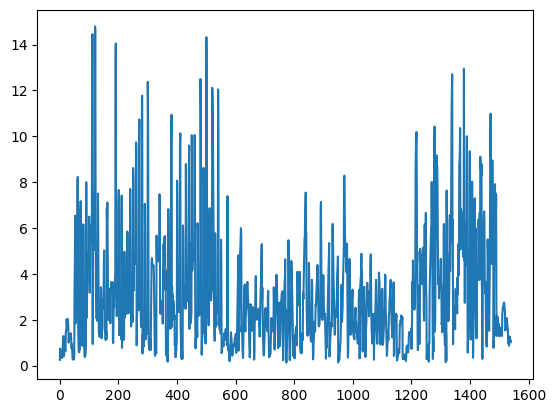

In [18]:
plt.plot(ee_run_01)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


plot_rows = 1
plot_cols = 2

fig = make_subplots(rows=plot_rows, cols=plot_cols,shared_xaxes=True,vertical_spacing=0.05, subplot_titles= ['Hor. Coord. Fixation', 'Ver. Coord. Fixation'])

# Set a common y-axis range
common_y_range = [-11, 11]  # Adjust the range as needed


fig.add_trace(go.Scatter(x=time_seconds_fix,y=fix_data[0,:,1] ,showlegend=True, name='Eyetracking',line=dict(color='#0E1C36', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(x=fix_data_pt_X[:, 1],y=fix_data_pt_X[:,0],showlegend=True, name='Pretrained', line=dict(color='#069D6B', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(x=time_seconds_fix,y=fix_data[0,:,2] ,showlegend=True, name='Eyetracking',line=dict(color='#0E1C36', width=2)), row = 1, col = 2)
fig.add_trace(go.Scatter(x=fix_data_pt_Y[:, 1],y=fix_pt_Y_inverted,showlegend=True, name='Pretrained', line=dict(color='#069D6B', width=2)), row = 1, col = 2)

fig.update_traces(showlegend=False, row=1, col=2)
# Format and show fig
fig.update_layout(height=600, width=1500, template="simple_white", title_text=f"Eyetracker Gaze Position (X,Y) vs. Pretrained Gaze Position", 
            yaxis1 = dict(title = "<b>Hor. coord. (dva)<b>", title_font=dict(size=12)),
            yaxis2 = dict(title = "<b>Ver. coord. (dva)<b>",title_font=dict(size=12)))
         


# Update subplot titles font
fig.update_annotations(font=dict(size=14))


#fig.show()
fig.write_image(f'sub-06_ee.pdf')



In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pur_pt_Y_inverted = -1.0 * pur_data_pt_Y[:,0]

plot_rows = 1
plot_cols = 2

fig = make_subplots(rows=plot_rows, cols=plot_cols,shared_xaxes=True,vertical_spacing=0.05, subplot_titles= ['Hor. Coord. Pursuit', 'Ver. Coord. Pursuit'])

# Set a common y-axis range
common_y_range = [-11, 11]  # Adjust the range as needed


fig.add_trace(go.Scatter(x=time_seconds_pur,y=pur_data[0,:,1],showlegend=True, name='Eyetracking',line=dict(color='#0E1C36', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(x=pur_data_ft_adjusted_time, y=pur_data_pt_X[:,0],showlegend=True, name='Pretrained', line=dict(color='#069D6B', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(x=time_seconds_pur,y=pur_data[0,:,2] ,showlegend=True, name='Eyetracking',line=dict(color='#0E1C36', width=2)), row = 1, col = 2)
fig.add_trace(go.Scatter(x=pur_data_ft_adjusted_time,y=pur_pt_Y_inverted,showlegend=True, name='Pretrained', line=dict(color='#069D6B', width=2)), row = 1, col = 2)

fig.update_traces(showlegend=False, row=1, col=2)
# Format and show fig
fig.update_layout(height=600, width=1500, template="simple_white", title_text=f"Eyetracker Gaze Position (X,Y) vs. Pretrained Gaze Position", 
            yaxis1 = dict(title = "<b>Hor. coord. (dva)<b>", title_font=dict(size=12)),
            yaxis2 = dict(title = "<b>Ver. coord. (dva)<b>",title_font=dict(size=12)))
         


# Update subplot titles font
fig.update_annotations(font=dict(size=14))


fig.show()
#fig.write_image(f'{subject}_scanner_gazeposition_eyetracker.pdf')



In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fv_pt_Y_inverted = -1.0 * fv_data_pt_Y[:,0]

plot_rows = 1
plot_cols = 2

fig = make_subplots(rows=plot_rows, cols=plot_cols,shared_xaxes=True,vertical_spacing=0.05, subplot_titles= ['Hor. Coord. Freeviewing', 'Ver. Coord. Freeviewing'])

# Set a common y-axis range
common_y_range = [-11, 11]  # Adjust the range as needed


fig.add_trace(go.Scatter(x=time_seconds_fv,y=fv_data[0,:,1] ,showlegend=True, name='Eyetracking',line=dict(color='#0E1C36', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(x=fv_data_ft_adjusted_time, y= fv_data_pt_X[:,0],showlegend=True, name='Pretrained', line=dict(color='#069D6B', width=2)), row = 1, col = 1)
fig.add_trace(go.Scatter(x=time_seconds_fv,y=fv_data[0,:,2] ,showlegend=True, name='Eyetracking',line=dict(color='#0E1C36', width=2)), row = 1, col = 2)
fig.add_trace(go.Scatter(x=fv_data_ft_adjusted_time, y= fv_pt_Y_inverted,showlegend=True, name='Pretrained', line=dict(color='#069D6B', width=2)), row = 1, col = 2)

fig.update_traces(showlegend=False, row=1, col=2)
# Format and show fig
fig.update_layout(height=600, width=1500, template="simple_white", title_text=f"Eyetracker Gaze Position (X,Y) vs. Pretrained Gaze Position", 
            yaxis1 = dict(title = "<b>Hor. coord. (dva)<b>", title_font=dict(size=12)),
            yaxis2 = dict(title = "<b>Ver. coord. (dva)<b>",title_font=dict(size=12)))
         


# Update subplot titles font
fig.update_annotations(font=dict(size=14))


fig.show()
#fig.write_image(f'/Users/sinakling/Desktop/freeview_pt.png')



In [20]:
import numpy as np
from scipy.signal import resample

def downsample_to_targetrate(original_data, eyetracking_rate, target_rate):
    """
    Downsample eye-tracking data to a specified target rate.

    Args:
        original_data (np.array): Eye-tracking data array with columns for timestamp, X, Y, and pupil size.
        eyetracking_rate (int): Sampling rate of the original data.
        target_rate (float): Desired target sampling rate.

    Returns:
        np.array: Downsampled eye-tracking data.
    """
    # Remove NaNs
    def remove_nans(data):
        for col in range(data.shape[1]):
            nan_indices = np.isnan(data[:, col])
            if np.any(nan_indices):
                data[nan_indices, col] = np.interp(
                    np.flatnonzero(nan_indices),
                    np.flatnonzero(~nan_indices),
                    data[~nan_indices, col]
                )
        return data

    original_data = remove_nans(original_data)

    # Calculate total number of data points in target rate
    eyetracking_in_sec = len(original_data) / eyetracking_rate
    total_target_points = int(eyetracking_in_sec * target_rate)

    # Resample data columns
    downsampled_t = np.linspace(
        original_data[0, 0], original_data[-1, 0], total_target_points
    )
    downsampled_x = resample(original_data[:, 1], total_target_points)
    downsampled_y = resample(original_data[:, 2], total_target_points)

    # Stack into final array
    downsampled_data = np.column_stack((downsampled_t, downsampled_x, downsampled_y))

    return downsampled_data



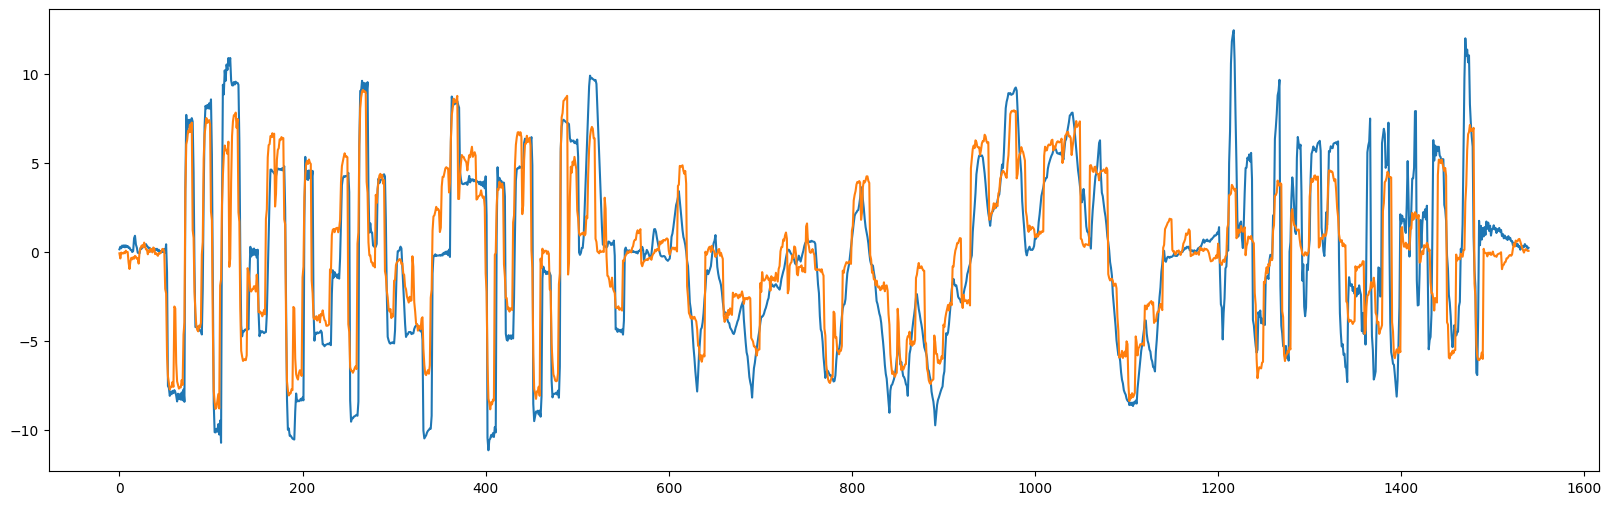

In [21]:
# length prediction = 154 * 1.2 = 184.8
# sampling frequency = 15400 / 184.8 = 8.33 Hz 


eye_data_downsampled = downsample_to_targetrate(eye_data, 1000, 8.33)
plt.figure(figsize=(20, 6))
plt.plot(eye_data_downsampled[:,1])
plt.plot(sub_06_run_01_X)

In [4]:
from scipy.signal import detrend, resample
import pandas as pd
import numpy as np
design_matrix = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/deepmreye_closed/exp_design/sub-03/sub-03_ses-02_task-DeepMReyeClosed_run-01_design_matrix.tsv", sep ="\t")
task_1_trials = np.array(design_matrix["task_eyes_open_task"])
task_3_trials = np.array(design_matrix["task_no_stimulus_task"])
task_4_trials = np.array(design_matrix["task_eyes_closed_task"])

resampled_task_1_trials = resample(task_1_trials, len(eye_data_downsampled[:,1]))
resampled_task_3_trials = resample(task_3_trials, len(eye_data_downsampled[:,1]))
resampled_task_4_trials = resample(task_4_trials, len(eye_data_downsampled[:,1]))

task_1_trials_bool = resampled_task_1_trials > 0.5
task_3_trials_bool = resampled_task_3_trials > 0.5
task_4_trials_bool = resampled_task_4_trials > 0.5

eye_data_task_1 = eye_data_downsampled[task_1_trials_bool]
eye_data_task_3 = eye_data_downsampled[task_3_trials_bool]
eye_data_task_4 = eye_data_downsampled[task_4_trials_bool]


NameError: name 'eye_data_downsampled' is not defined

In [22]:
def euclidean_distance(eye_data, pred_x, pred_y): 
     eucl_dist = np.sqrt(
        (eye_data[:, 1] - pred_x)**2 + (eye_data[:, 2] - pred_y)**2)

     return eucl_dist

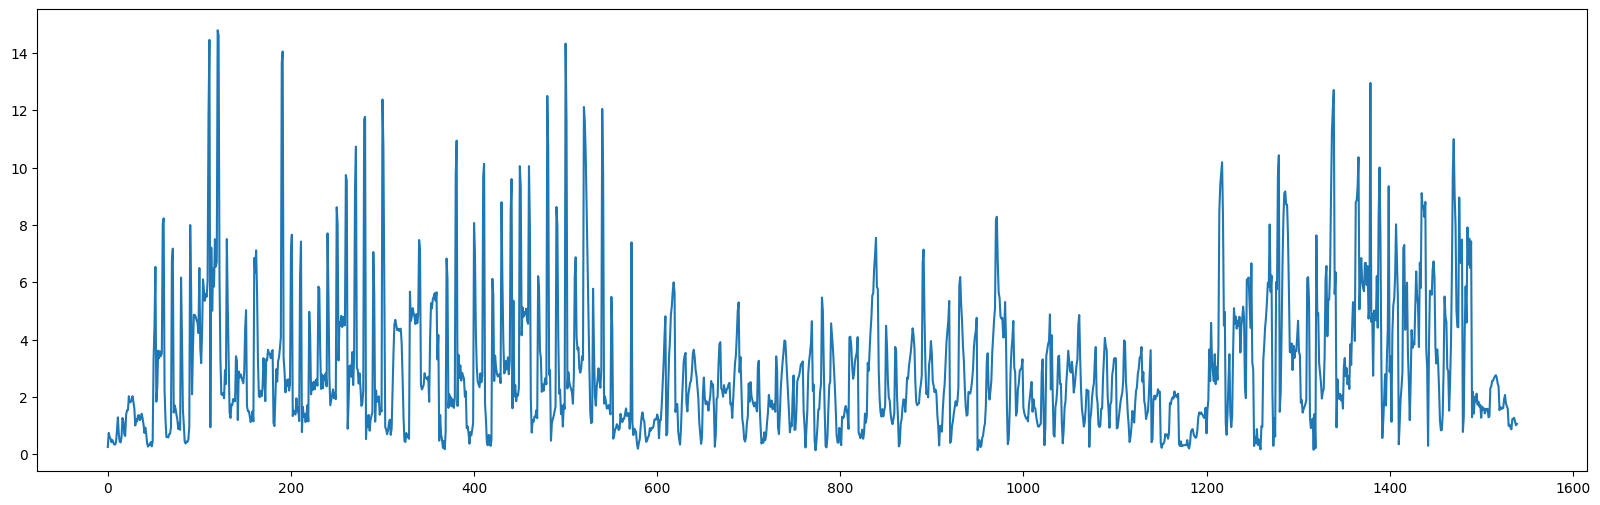

In [23]:
ee_ft = euclidean_distance(eye_data_downsampled, sub_06_run_01_X, sub_06_run_01_Y)
plt.figure(figsize=(20, 6))
plt.plot(ee_ft)

In [30]:
ee_run_01 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/sub-06/eyetracking/sub-06_task-DeepMReyeCalib_subtask-all_run_01_ee.tsv.gz", compression='gzip', delimiter='\t')
ee_run_01 = ee_run_01[['ee']].to_numpy()

ee_run_02 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/sub-06/eyetracking/sub-06_task-DeepMReyeCalib_subtask-all_run_02_ee.tsv.gz", compression='gzip', delimiter='\t')
ee_run_02 = ee_run_02[['ee']].to_numpy()

ee_run_03 = pd.read_csv(f"/Users/sinakling/disks/meso_shared/deepmreye/derivatives/pp_data/sub-06/eyetracking/sub-06_task-DeepMReyeCalib_subtask-all_run_03_ee.tsv.gz", compression='gzip', delimiter='\t')
ee_run_03 = ee_run_03[['ee']].to_numpy()

In [24]:
print(np.mean(ee_ft))  #according to model error: 2.338

2.981012760295093


In [25]:
import numpy as np

def distance_at_fraction(eucl_dist, fraction=0.75):
    """
    Get the distance threshold below which a certain fraction of the data falls.

    Parameters:
        eucl_dist (np.ndarray): Array of Euclidean distances.
        fraction (float): Fraction of data (between 0 and 1). Default is 0.75 (75%).

    Returns:
        float: Distance threshold for the given fraction.
    """
    # Convert fraction to percentage for np.percentile
    percentile = fraction * 100
    distance_threshold = np.percentile(eucl_dist, percentile)
    return distance_threshold

# Example usage:
eucl_dist = ee_ft
threshold_75 = distance_at_fraction(eucl_dist, fraction=0.75)
print(f"The distance below which 75% of the data falls is: {threshold_75}")


The distance below which 75% of the data falls is: 3.9102460171048095


In [31]:
threshold_75_1 = distance_at_fraction(ee_run_01, fraction=0.75)
print(f"The distance below which 75% of the data in run 1 falls is: {threshold_75_1}")

threshold_75_2 = distance_at_fraction(ee_run_02, fraction=0.75)
print(f"The distance below which 75% of the data in run 1 falls is: {threshold_75_2}")

threshold_75_3 = distance_at_fraction(ee_run_03, fraction=0.75)
print(f"The distance below which 75% of the data in run 1 falls is: {threshold_75_3}")

The distance below which 75% of the data in run 1 falls is: 3.9102460171048117
The distance below which 75% of the data in run 1 falls is: 4.064550141271528
The distance below which 75% of the data in run 1 falls is: 3.6604895982173864


In [33]:
import statistics
print(statistics.mean([threshold_75_1,threshold_75_2,threshold_75_3]))

3.878428585531242


In [34]:
import numpy as np
from scipy.stats import sem, t

def percentile_ci_from_runs(runs_data, fraction=0.75, confidence=0.95):
    """
    Calculate the mean percentile and confidence interval from multiple runs.

    Parameters:
        runs_data (list of np.ndarray): List of Euclidean distance arrays, one for each run.
        fraction (float): Fraction for the percentile (default 0.75 for 75%).
        confidence (float): Confidence level (default 0.95 for 95%).

    Returns:
        tuple: (mean percentile, lower CI bound, upper CI bound)
    """
    # Compute the percentile for each run
    percentiles = [np.percentile(run, fraction * 100) for run in runs_data]

    # Mean and SEM of percentiles
    mean_percentile = np.mean(percentiles)
    stderr = sem(percentiles)  # Standard error of the mean

    # Calculate confidence interval
    t_multiplier = t.ppf((1 + confidence) / 2, df=len(percentiles) - 1)
    margin_of_error = t_multiplier * stderr
    lower_bound = mean_percentile - margin_of_error
    upper_bound = mean_percentile + margin_of_error

    return mean_percentile, lower_bound, upper_bound


mean_percentile, lower_ci, upper_ci = percentile_ci_from_runs([ee_run_01, ee_run_02, ee_run_03])
print(f"Mean 75th Percentile: {mean_percentile:.2f}, 95% CI: ({lower_ci:.2f}, {lower_ci:.2f})")


Mean 75th Percentile: 3.88, 95% CI: (3.37, 4.38)


In [ ]:
#TODO script for ee percentile 
#TODO save for each subject 
#TODO mean over all subjects 
#TODO box plots (standard deviation?)

In [154]:
def fraction_under_threshold(pred, eucl_dist):
    import numpy as np
    thresholds = np.linspace(0, 9.0, 100)
    precision = []

    for thr in thresholds: 
        count = np.sum(eucl_dist < thr)
        fraction = count / len(pred) 
        precision.append(fraction)
    
    return precision

In [155]:
precision_fraction = fraction_under_threshold(sub_06_run_01_X, ee_ft)

(401507,)


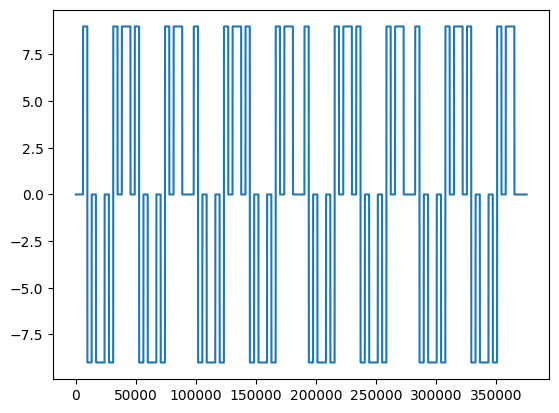

In [14]:
import numpy as np
import matplotlib.pyplot as plt
closed_test_x = np.load("/Users/sinakling/projects/deepmreyeclosed/analysis_code/expected_x_data_Closed_sub-04_run_1.npy")
closed_test_y = np.load("/Users/sinakling/projects/deepmreyeclosed/analysis_code/expected_y_data_Closed_sub-04_run_1.npy")
print(closed_test_x.shape)
plt.plot(closed_test_x[:375600])

In [11]:
print(313 * 1000 * 1.2)

375600.0


In [4]:
def downsample_to_tr(original_data, eyetracking_rate):
    """
    Downsample eye-tracking data to match the temporal resolution of functional MRI TRs.

    Args:
        original_data (np.array): 1D array of eye-tracking data (e.g., X or Y coordinates).
        eyetracking_rate (int): The sampling rate of the eye-tracking data.

    Returns:
        np.array: Resampled data reshaped to match TRs.
    """
    from scipy.signal import resample
    target_points_per_tr = 10  # 10 data points per 1.2 seconds
    tr_duration = 1.2  # 1.2 sec
    target_rate = target_points_per_tr / tr_duration  # 8.33 Hz

    # Calculate total number of data points in target rate
    eyetracking_in_sec = len(original_data) / eyetracking_rate  # 185 sec
    total_target_points = int(eyetracking_in_sec * target_rate) # 1541

    # Resample the data
    downsampled_data = resample(original_data, total_target_points) # resample into amount of wanted data points

    # Reshape into TRs
    num_trs = int(eyetracking_in_sec / tr_duration) 

    reshaped_data = downsampled_data[:num_trs * target_points_per_tr].reshape(num_trs, target_points_per_tr)

    # Check new shape
    print(reshaped_data.shape)

    return reshaped_data

In [17]:
closed_test_x_ds = downsample_to_tr(closed_test_x[:375600],1000)
closed_test_y_ds = downsample_to_tr(closed_test_y[:375600],1000)

stacked_array = np.stack((closed_test_x_ds, closed_test_y_ds), axis=-1)

print(stacked_array.shape)

np.save("/Users/sinakling/Desktop/expected_position_closed", stacked_array)

(313, 10)
(313, 10)
(313, 10, 2)
